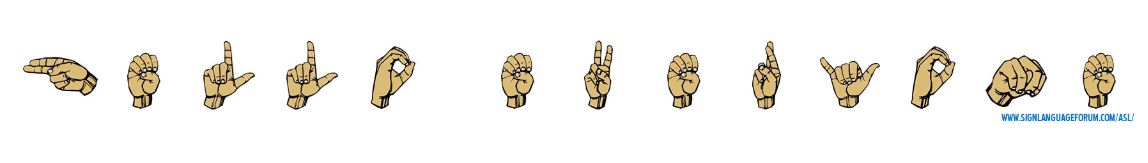
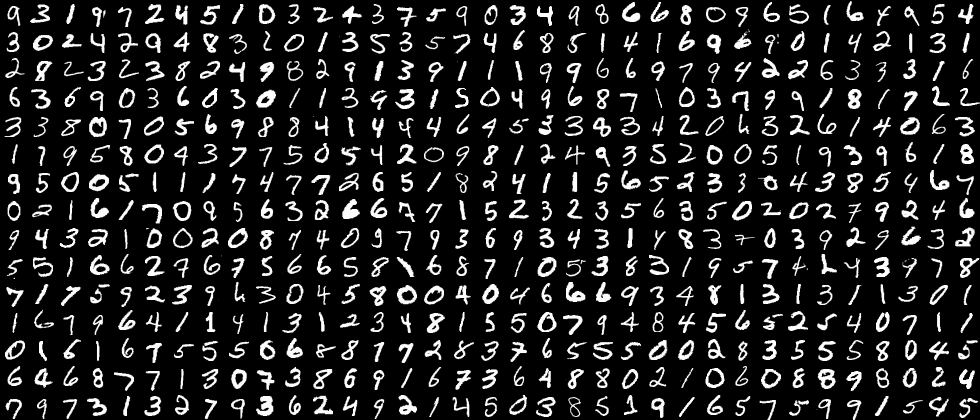

# Hand Written Digits Project

In [ ]:
!pip install -qq pandas==1.4.3 matplotlib==3.5.2 seaborn==0.11.2 plotly==5.10.0 scikit-learn==1.1.2 yellowbrick==1.5 numpy==1.22.2

## 1.1 Import Libraries 

In [1]:
import warnings
from typing import Tuple, Dict, Union

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline  import Pipeline

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from yellowbrick.classifier import ClassPredictionError, ROCAUC
from yellowbrick.classifier import ROCAUC

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (10, 8)
sns.set_style("whitegrid")

warnings.filterwarnings('ignore')

# Exploratory Data Analysis and Visualization

In [2]:
df = pd.read_csv("/kaggle/input/pendigits/pendigits_txt.csv")
df.head()

,input1,input2,input3,input4,input5,input6,input7,input8,input9,input10,input11,input12,input13,input14,input15,input16,class
0,47,100,27,81,57,37,26,0,0,23,56,53,100,90,40,98,8
1,0,89,27,100,42,75,29,45,15,15,37,0,69,2,100,6,2
2,0,57,31,68,72,90,100,100,76,75,50,51,28,25,16,0,1
3,0,100,7,92,5,68,19,45,86,34,100,45,74,23,67,0,4
4,0,67,49,83,100,100,81,80,60,60,40,40,33,20,47,0,1


In [3]:
def summary(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function takes the target dataframe and checks the following:
        - num_rows
        - data_types
        - counts
        - min_values
        - max_values
        - uniques
        - nulls
    for all of the available columns.
    
    Args:
        df: The target dataframe.
        
    Returns:
        Summary dataframe with mentioned columns.
    """
        
    num_rows = df.shape[0]
    
    data_types = df.dtypes
    counts = df.apply(lambda x: x.count())
    
    min_value = df.min()
    max_value = df.max()
    
    uniques = df.apply(lambda x: x.unique().shape[0])
    nulls = df.apply(lambda x: x.isnull().sum())
    
    print('Data shape:', df.shape)

    cols = ['data_types', 'counts', 'uniques', 'nulls', 'min_value', 'max_value']
    summary_df = pd.concat([data_types, counts, uniques, nulls, min_value, max_value],
                            axis = 1, sort = True)

    summary_df.columns = cols
    
    print('___________________________\nData Types:')
    print(summary_df["data_types"].value_counts())
    print('___________________________')
    
    return summary_df

summary(df)

Data shape: (10992, 17)
___________________________
Data Types:
int64    17
Name: data_types, dtype: int64
___________________________


,data_types,counts,uniques,nulls,min_value,max_value
class,int64,10992,10,0,0,9
input1,int64,10992,101,0,0,100
input10,int64,10992,101,0,0,100
input11,int64,10992,101,0,0,100
input12,int64,10992,101,0,0,100
input13,int64,10992,101,0,0,100
input14,int64,10992,101,0,0,100
input15,int64,10992,101,0,0,100
input16,int64,10992,101,0,0,100
input2,int64,10992,96,0,0,100


# Data Cleaning

Detect Missing Values and Outliers

Burada tüm değerlerin dolu olduğunu görüyoruz.

In [4]:
df.isna().any().any()

False

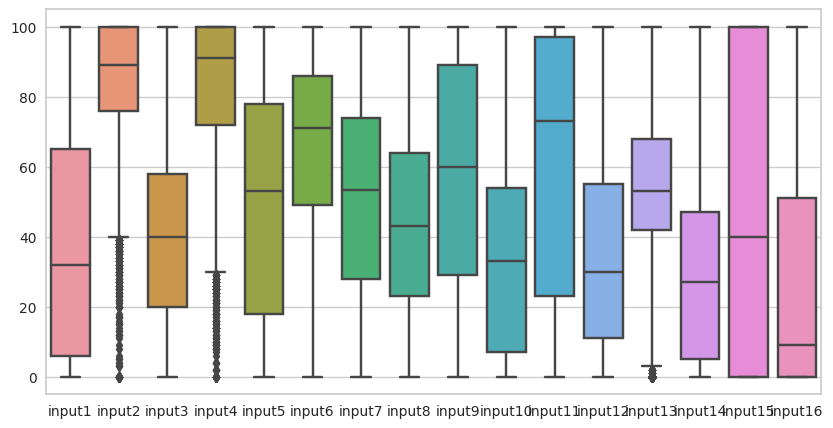

In [5]:
plt.figure(figsize = (10,5))
sns.boxplot(data = df.drop("class", axis = 1))
plt.show()

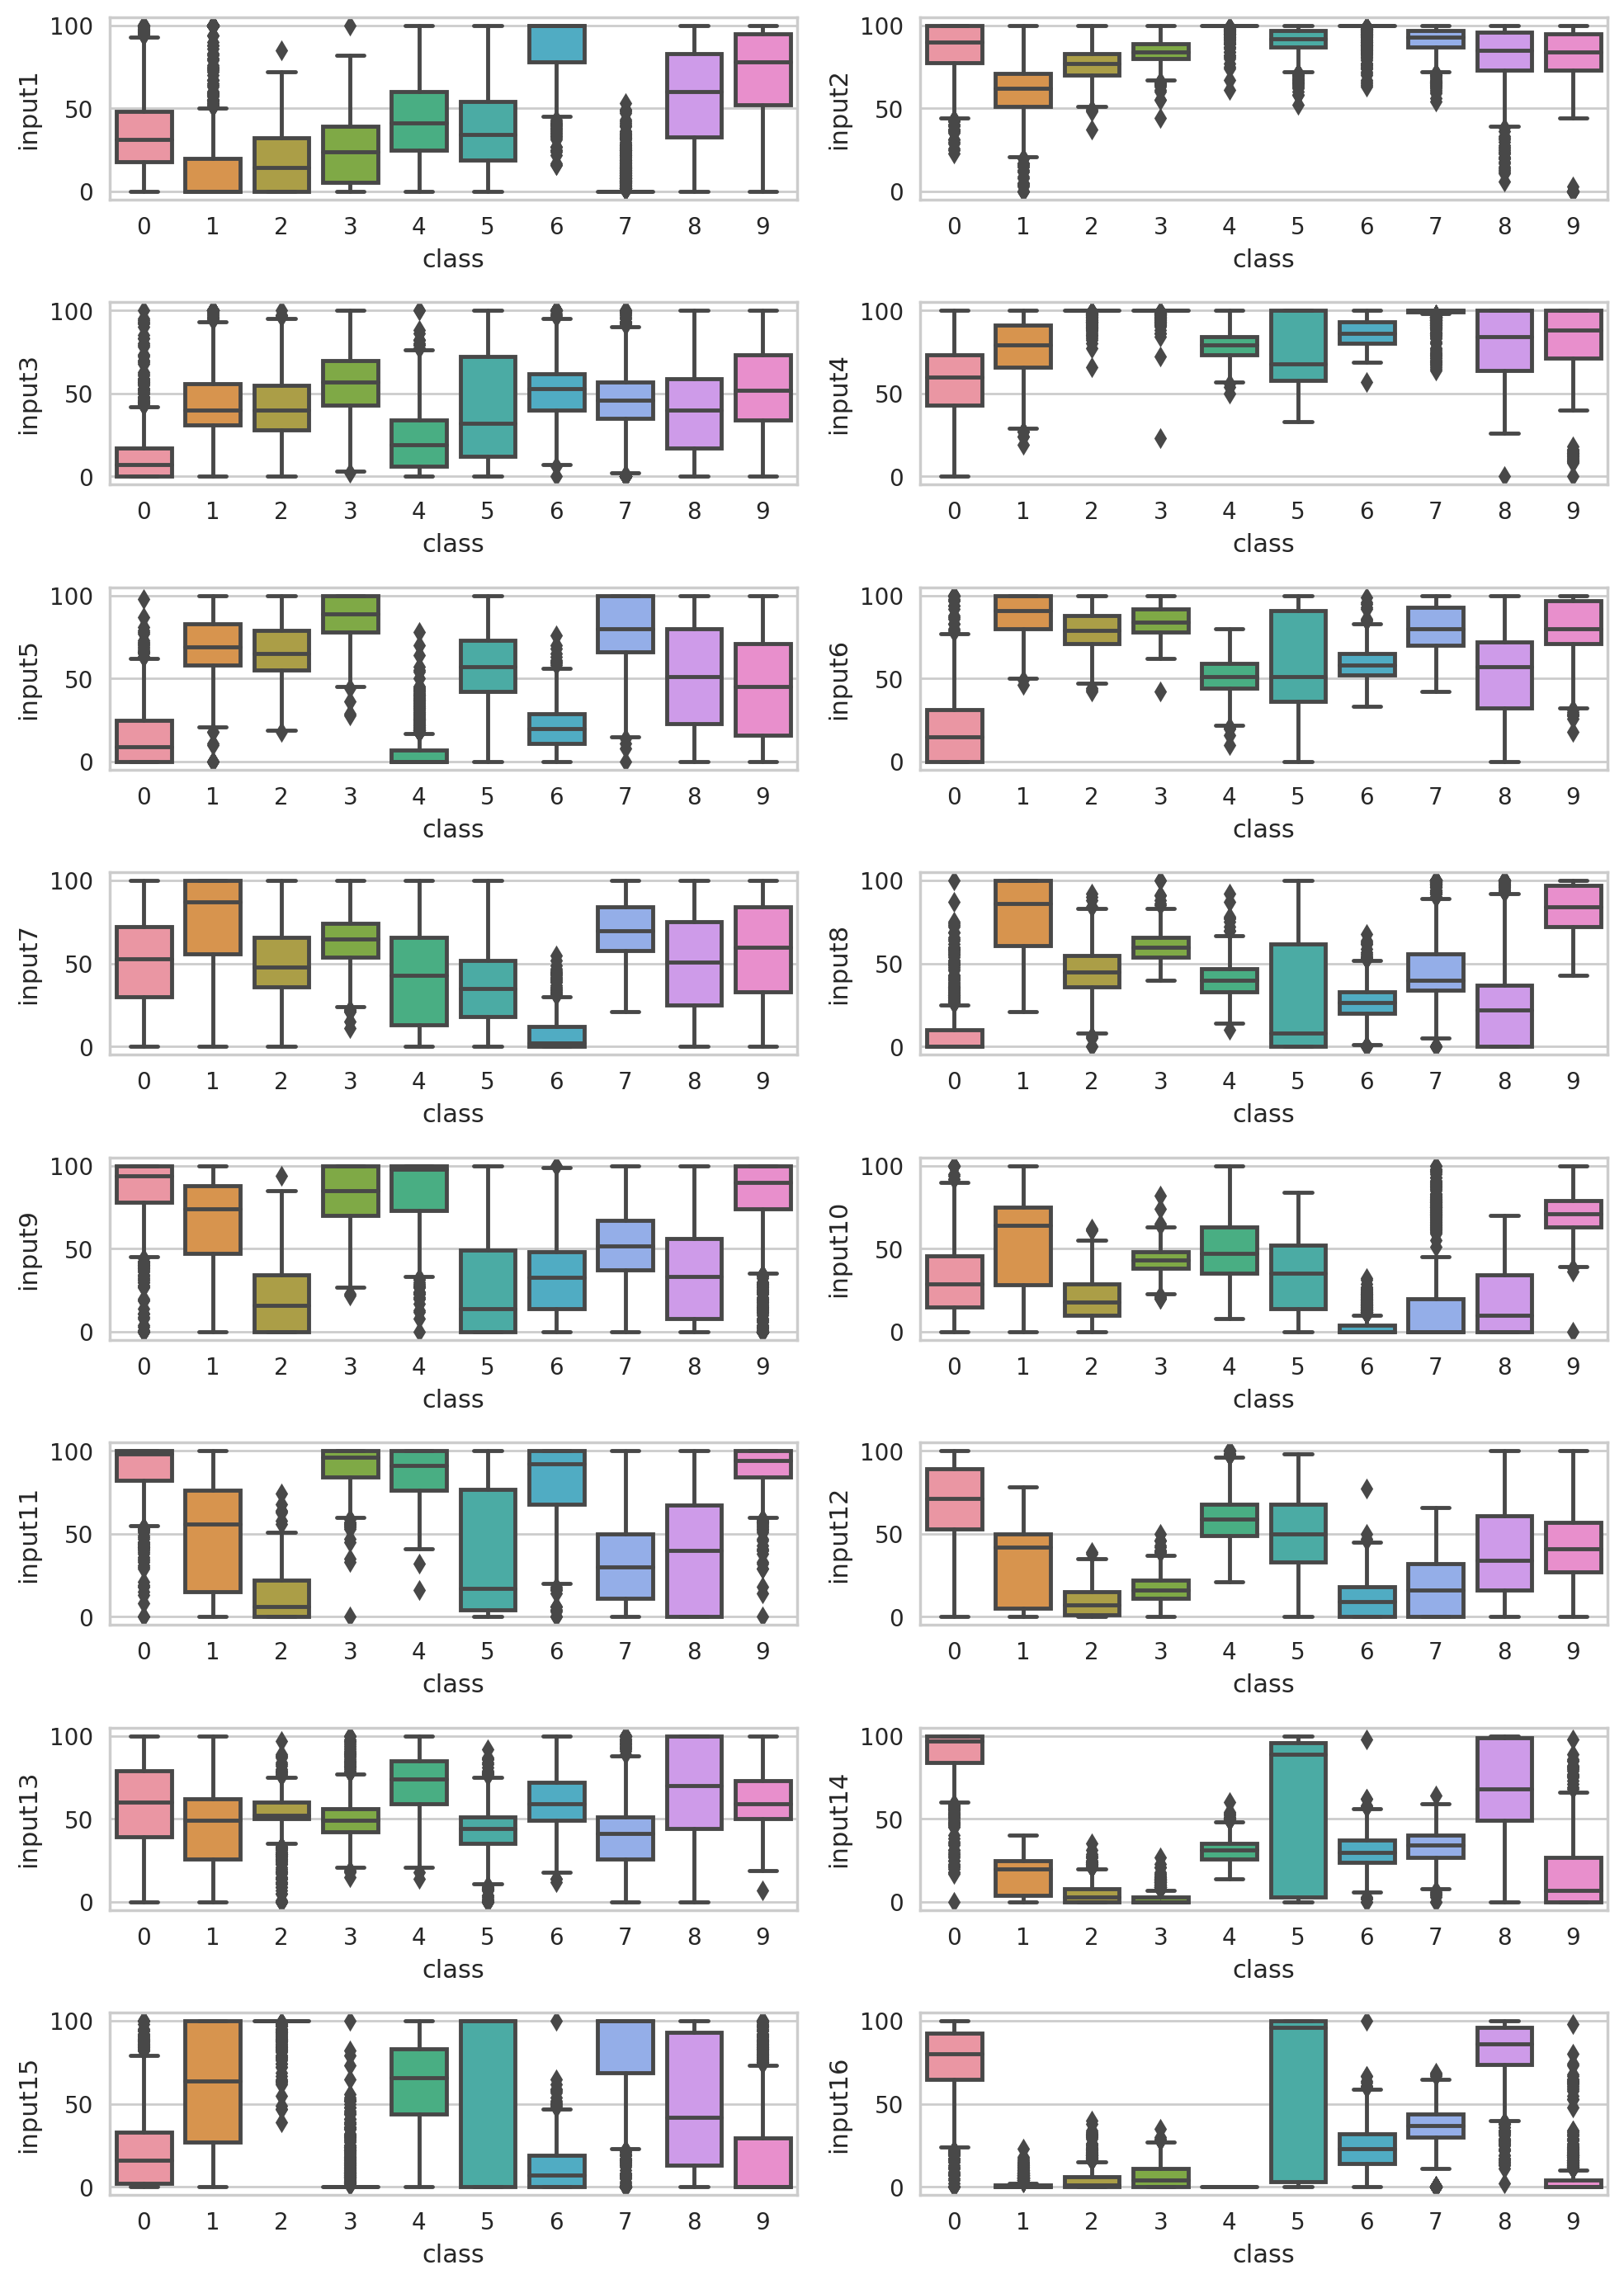

In [6]:
fig = plt.figure(figsize=(10,14), dpi=200)

for i, col in enumerate(df.columns[:-1]):
        plt.subplot(8,2,i+1)
        sns.boxplot(y= df[col], x = df["class"], data=df)

plt.tight_layout()
plt.show()

In [7]:
def detect_outliers(df: pd.DataFrame,
                    col_name: str,
                    iqr_range: float = 1.5) -> Tuple[float, float, int]:
    """ 
    This function detects outliers based on 1.5 IQR and
    returns the number of lower and upper limit and number
    of outliers respectively
    
    Args:
        df: Target dataframe
        col_name: Target column in the dataframe
        iqr_range: The range for the IQR. Defaults to `1.5`.
        
    Returns:
        Tuple of lower_limit, upper_limit, outlier_count.
    """
    
    values = df[col_name].values
    
    first_quartile = np.percentile(values, 25)
    third_quartile = np.percentile(values, 75)
    
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile + (iqr_range * IQR)
    lower_limit = first_quartile - (iqr_range * IQR)
    
    outliers_mask = (values < lower_limit) | (values > upper_limit)
    outlier_count = np.sum(outliers_mask)
            
    return lower_limit, upper_limit, outlier_count

In [8]:
threshold = 1.5
outlier_info = {}

for col in df.columns:
    lower_lim, upper_lim, outlier_cnt = detect_outliers(df, col, threshold)
    print(f"{col} \tlower:{lower_lim} \tupper:{upper_lim}\toutlier:{outlier_cnt} \n*-*-*-*-*-*-*")
    
    outlier_info[col] = outlier_cnt

out_cols = [col for col, cnt in outlier_info.items() if cnt > 0]

print(out_cols)

input1 	lower:-82.5 	upper:153.5	outlier:0 
*-*-*-*-*-*-*
input2 	lower:40.0 	upper:136.0	outlier:196 
*-*-*-*-*-*-*
input3 	lower:-37.0 	upper:115.0	outlier:0 
*-*-*-*-*-*-*
input4 	lower:30.0 	upper:142.0	outlier:153 
*-*-*-*-*-*-*
input5 	lower:-72.0 	upper:168.0	outlier:0 
*-*-*-*-*-*-*
input6 	lower:-6.5 	upper:141.5	outlier:0 
*-*-*-*-*-*-*
input7 	lower:-41.0 	upper:143.0	outlier:0 
*-*-*-*-*-*-*
input8 	lower:-38.5 	upper:125.5	outlier:0 
*-*-*-*-*-*-*
input9 	lower:-61.0 	upper:179.0	outlier:0 
*-*-*-*-*-*-*
input10 	lower:-63.5 	upper:124.5	outlier:0 
*-*-*-*-*-*-*
input11 	lower:-88.0 	upper:208.0	outlier:0 
*-*-*-*-*-*-*
input12 	lower:-55.0 	upper:121.0	outlier:0 
*-*-*-*-*-*-*
input13 	lower:3.0 	upper:107.0	outlier:208 
*-*-*-*-*-*-*
input14 	lower:-58.0 	upper:110.0	outlier:0 
*-*-*-*-*-*-*
input15 	lower:-150.0 	upper:250.0	outlier:0 
*-*-*-*-*-*-*
input16 	lower:-76.5 	upper:127.5	outlier:0 
*-*-*-*-*-*-*
class 	lower:-5.5 	upper:14.5	outlier:0 
*-*-*-*-*-*-*
['input2

In [9]:
out_cols

['input2', 'input4', 'input13']

In [10]:
df1 = df.copy()

In [11]:
outliers = detect_outliers(df1, out_cols)
df1 = df1[~df1.isin(outliers)]

In [12]:
df1.shape

(10992, 17)

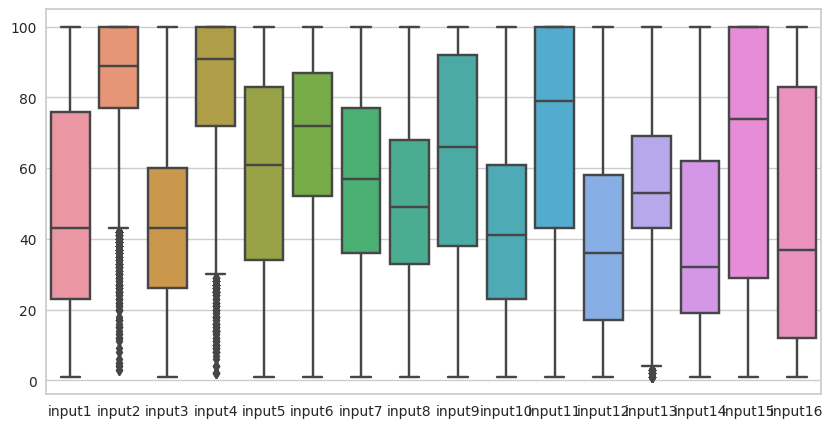

In [13]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df1.drop("class", axis=1))
plt.show()

## Target = Class

In [14]:
df['class'].value_counts(normalize = True) * 100 

2    10.407569
4    10.407569
1    10.398472
0    10.398472
7    10.389374
6     9.606987
8     9.597889
5     9.597889
9     9.597889
3     9.597889
Name: class, dtype: float64

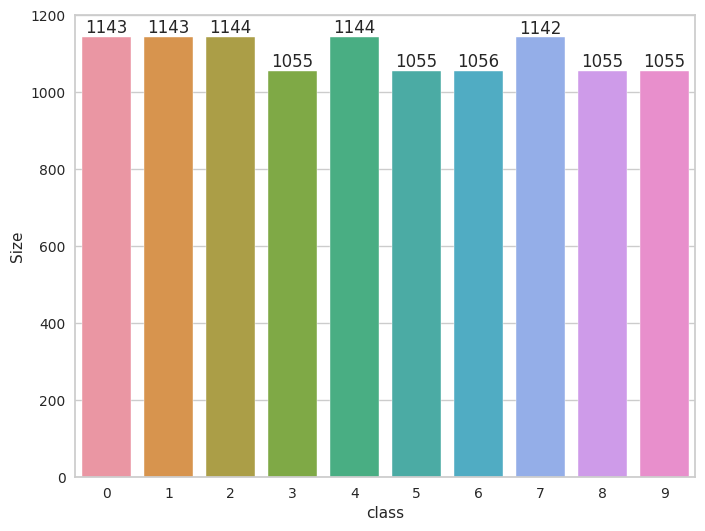

In [15]:
class_digit = df.groupby('class').size()
class_label = pd.DataFrame(class_digit, columns = ['Size'])

plt.figure(figsize = (8, 6))
ax = sns.barplot(x = class_label.index, y = 'Size', data = class_label)

plt.bar_label(ax.containers[0])
plt.show()

In [16]:
corr_matrix = df.corr()

corr_filtered = corr_matrix[(abs(df.corr()) >= 0.9) & (abs(df.corr()) < 1)]
corr_filtered.any().any()

False

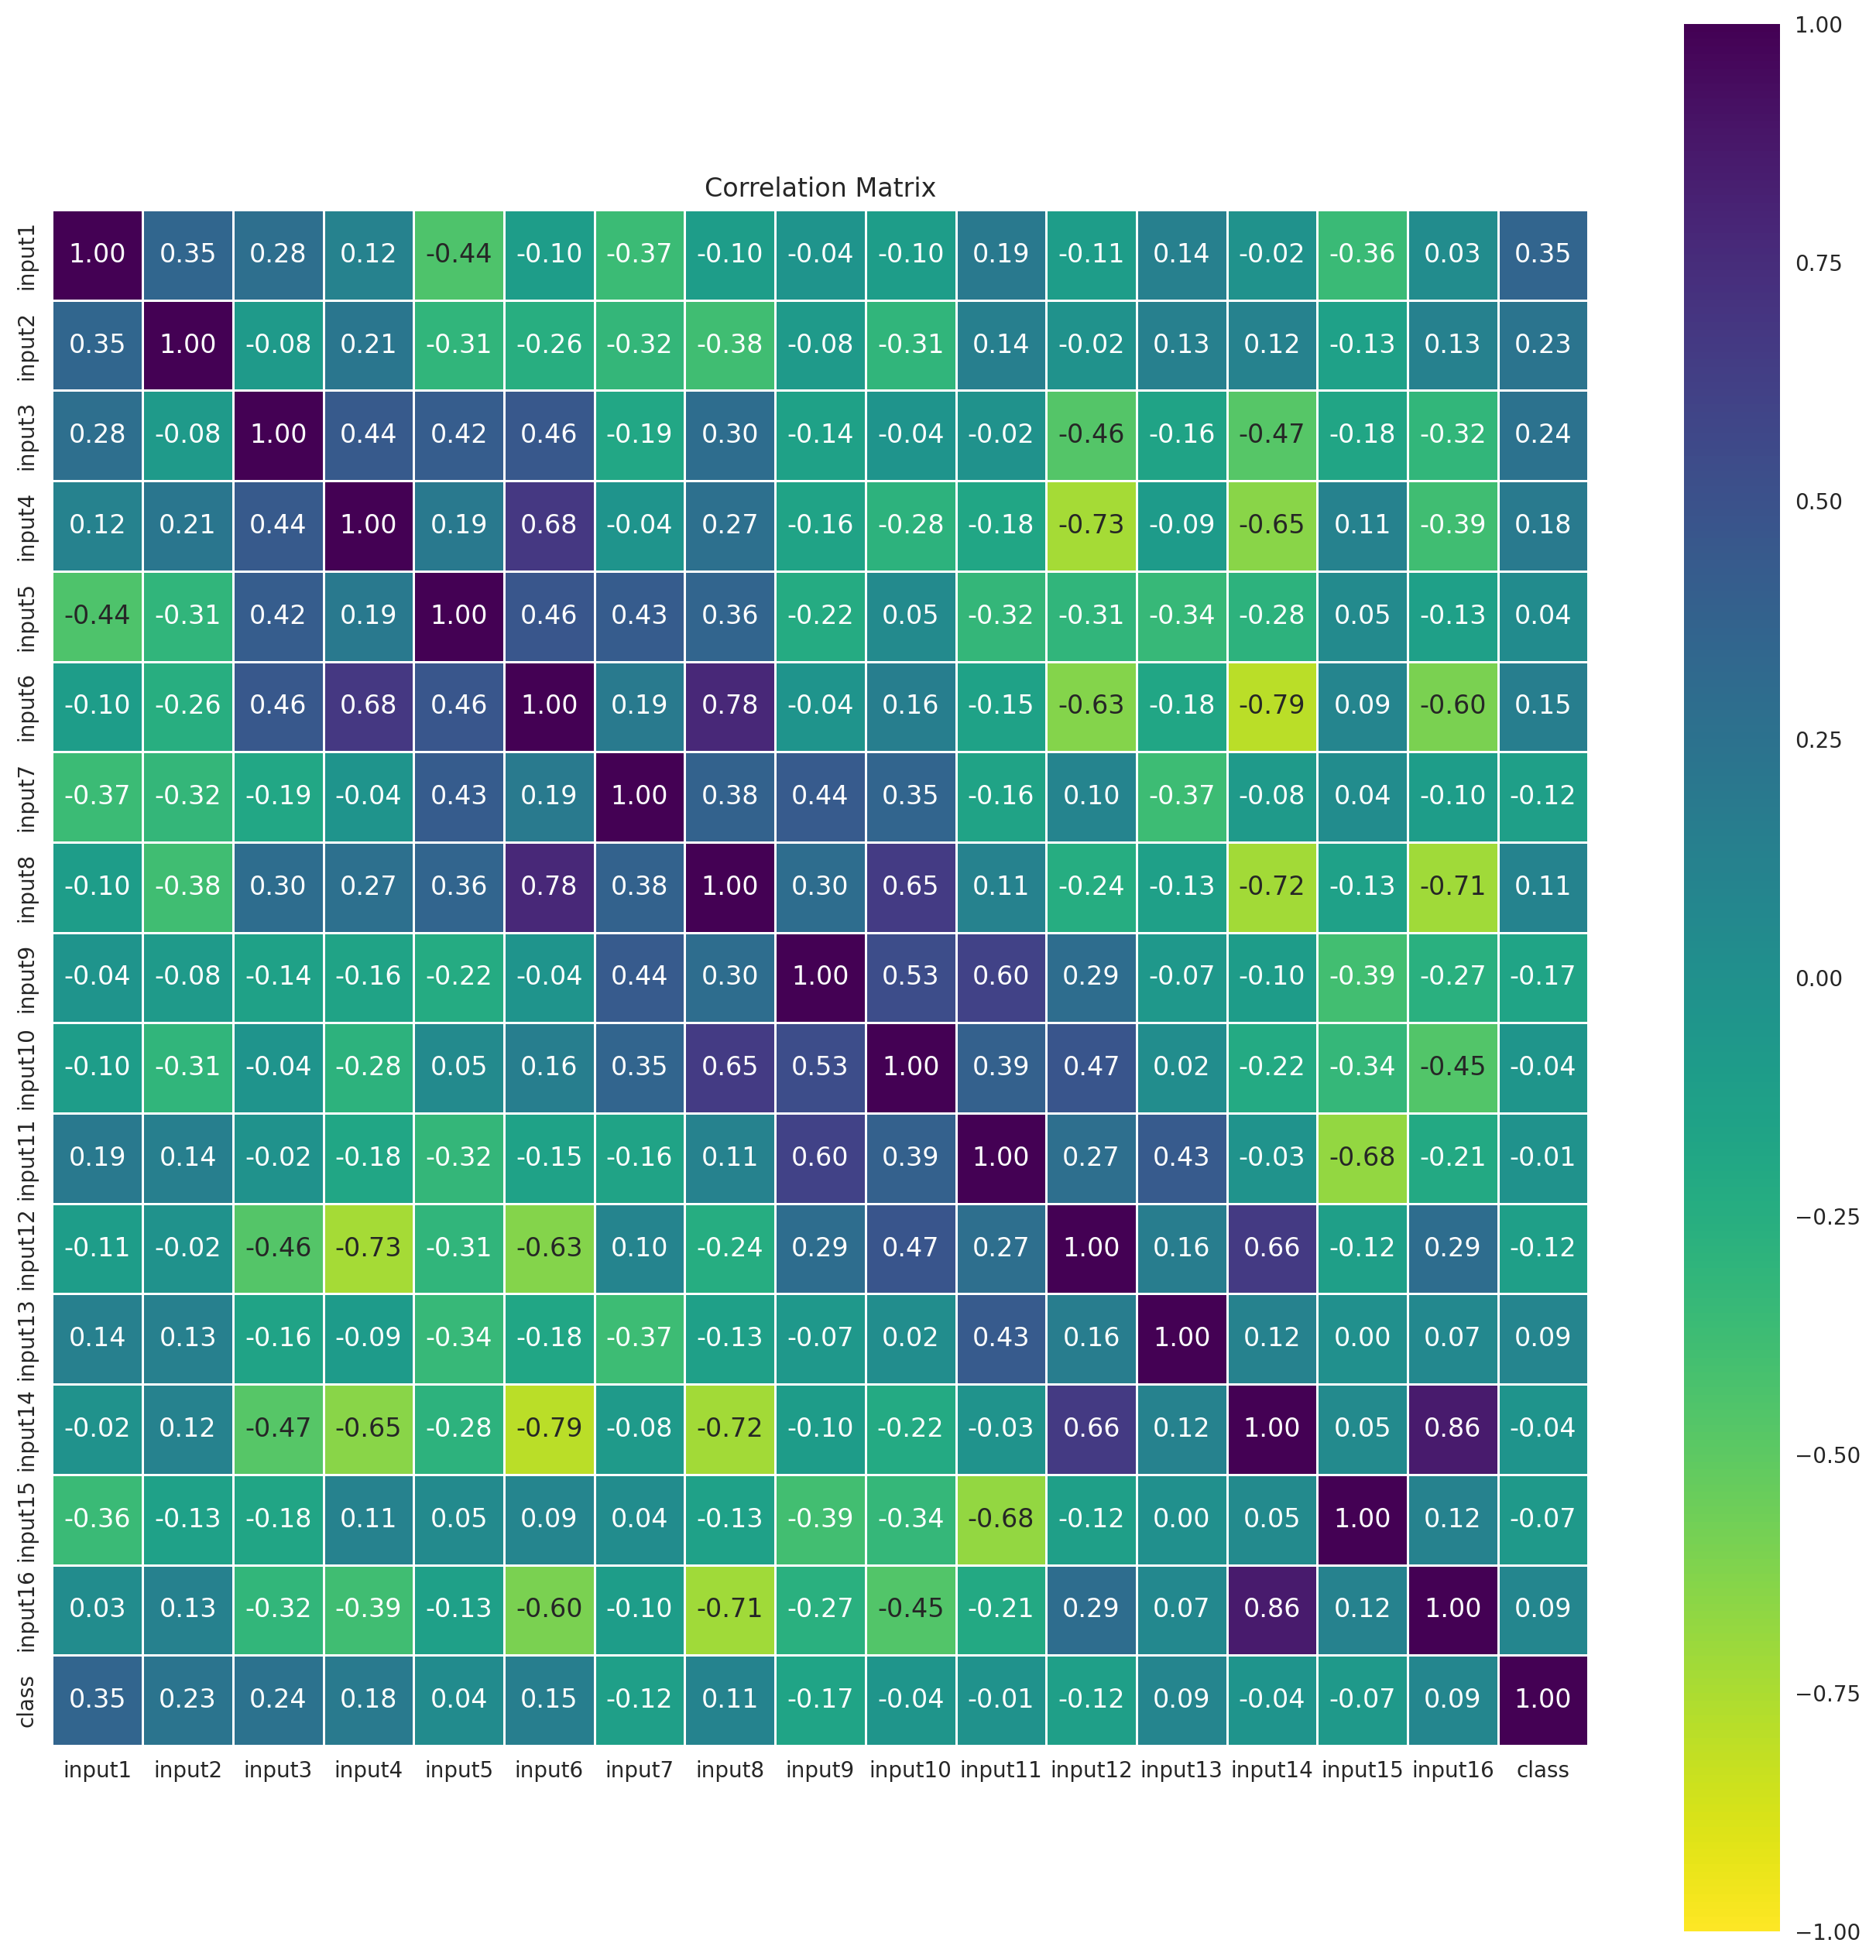

In [17]:
plt.figure(figsize=(16, 16), dpi = 200)
sns.heatmap(corr_matrix,
            square = True,
            annot = True,
            fmt=".2f",
            annot_kws={"size": 12},
            linewidths=.5,
            vmin=-1, vmax=1,
            cmap='viridis_r')

plt.title("Correlation Matrix")
plt.show()

In [18]:
corr_matrix['class'].sort_values(key=abs, ascending=False)

class      1.000000
input1     0.352199
input3     0.243030
input2     0.232075
input4     0.183646
input9    -0.170221
input6     0.153520
input12   -0.123672
input7    -0.123090
input8     0.108829
input13    0.089234
input16    0.085062
input15   -0.071037
input10   -0.044632
input5     0.039919
input14   -0.036312
input11   -0.011499
Name: class, dtype: float64

# Multi-class Classification

In [19]:
# df = pd.read_csv("/kaggle/input/pendigits/pendigits_txt.csv")
# df.head()

In [20]:
X = df.drop("class", axis = 1)
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size = 0.25)

# Support Vector Machine

## Vanilla SVC

In [21]:
scaler = MinMaxScaler()

In [22]:
def train_and_evaluate(estimator,
                       data: Dict[str, Union[np.ndarray, pd.Series]],
                       average: str = 'macro') -> Dict[str, Union[Dict[str, float], np.ndarray]]:
    """
    Train and evaluate a given estimator using the provided data.

    Args:
        estimator: The estimator to be trained and evaluated.
        data (Dict): Dictionary containing the training and test data.
                     Expected keys: 'X_train', 'y_train', 'X_test', 'y_test'.
        average (str, optional): The type of average to use when calculating the F1 score.
                                Defaults to 'macro'.

    Returns:
        Dict[str, Union[Dict[str, float], np.ndarray]]: Dictionary containing accuracy and F1 score for both
                                                       training and test data, along with the predictions.
    """

    estimator.fit(data['X_train'], data['y_train'])

    y_train_pred = estimator.predict(data['X_train'])
    train_predictions = {'train': (data['y_train'], y_train_pred)}

    y_test_pred = estimator.predict(data['X_test'])
    test_predictions = {'test': (data['y_test'], y_test_pred)}

    train_results = evaluate_model(train_predictions, average=average)
    test_results = evaluate_model(test_predictions, average=average)

    return {
        'train_metrics': {
            'accuracy': train_results[0],
            'f1_score': train_results[1]
        },
        'test_metrics': {
            'accuracy': test_results[0],
            'f1_score': test_results[1]
        },
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred
    }


In [23]:
def evaluate_model(predictions: dict, 
                   average: str = 'macro'):
    """
    Evaluate model results based on basic accuracy and F1 score measurements.

    Args:
        predictions (dictionary): The model predictions, stored as a dictionary or list.
        average (str, optional): The type of average to use when calculating the F1 score.
                                Defaults to 'macro'.

    Returns:
        List[float]: List of basic accuracy results followed by a list of F1 scores.
    """
    
    accuracy_results = [accuracy_score(y, y_pred) for y, y_pred in predictions.values()]
    f1_results = [f1_score(y, y_pred, average=average) for y, y_pred in predictions.values()]

    return accuracy_results + f1_results

In [24]:
svc_pipeline = Pipeline([("scaler", scaler),
                         ("SVM", SVC(kernel="rbf"))]) 

svc_param_grid = {'SVM__C': np.linspace(1, 1.3, 10),
              'SVM__gamma': ["scale", "auto"]}

svc_model_grid = GridSearchCV(svc_pipeline,
                              svc_param_grid,
                              verbose=1,
                              scoring="accuracy",
                              n_jobs=-1)


rfc = RandomForestClassifier(n_estimators=100)
rfc_param_grid = {'criterion': ["entropy","gini"],
             'max_depth': [7,8],
             'max_features': [' ', 0.8],
             'max_leaf_nodes': [180,200],
             'n_estimators': [50,100]}

rf_grid_model = GridSearchCV(rfc,
                             rfc_param_grid,
                             verbose=1,
                             scoring="accuracy",
                             n_jobs=-1)

In [25]:
data = {
    'X_train': X_train,
    'y_train': y_train,
    'X_test': X_test,
    'y_test': y_test
}

estimators = {
    'svc_pipeline': svc_pipeline,
    'svc_model_grid': svc_model_grid,
    'rfc': rfc,
    'rf_grid_model': rf_grid_model
}

results = {}

for name, estimator in estimators.items():
    print(f"Fitting model {name}")
    result = train_and_evaluate(estimator, data)
    results[name] = result
    print("**" * 10)

results

Fitting model svc_pipeline
********************
Fitting model svc_model_grid
Fitting 5 folds for each of 20 candidates, totalling 100 fits
********************
Fitting model rfc
********************
Fitting model rf_grid_model
Fitting 5 folds for each of 32 candidates, totalling 160 fits
********************


{'svc_pipeline': {'train_metrics': {'accuracy': 0.995147986414362,
   'f1_score': 0.9951366902306834},
  'test_metrics': {'accuracy': 0.992721979621543,
   'f1_score': 0.992737518419251},
  'y_train_pred': array([6, 4, 7, ..., 7, 4, 0]),
  'y_test_pred': array([8, 9, 2, ..., 7, 6, 8])},
 'svc_model_grid': {'train_metrics': {'accuracy': 0.9953905870936438,
   'f1_score': 0.9953810890923498},
  'test_metrics': {'accuracy': 0.9930858806404658,
   'f1_score': 0.9931121009365341},
  'y_train_pred': array([6, 4, 7, ..., 7, 4, 0]),
  'y_test_pred': array([8, 9, 2, ..., 7, 6, 8])},
 'rfc': {'train_metrics': {'accuracy': 1.0, 'f1_score': 1.0},
  'test_metrics': {'accuracy': 0.9887190684133915,
   'f1_score': 0.9888216757829088},
  'y_train_pred': array([6, 4, 9, ..., 7, 4, 0]),
  'y_test_pred': array([8, 9, 2, ..., 7, 6, 8])},
 'rf_grid_model': {'train_metrics': {'accuracy': 0.9935710819990295,
   'f1_score': 0.9936683264256629},
  'test_metrics': {'accuracy': 0.9814410480349345,
   'f1_score':

In [26]:
def print_metrics(y_train: np.ndarray, 
                  y_pred_train: np.ndarray,
                  y_test: np.ndarray,
                  y_pred_test: np.ndarray):
    """
    Print the confusion matrix and classification report for both training and test data.

    Args:
        y_train (np.ndarray): True labels for the training data.
        y_pred_train (np.ndarray): Predicted labels for the training data.
        y_test (np.ndarray): True labels for the test data.
        y_pred_test (np.ndarray): Predicted labels for the test data.
    """

    print("TEST CM\n", confusion_matrix(y_test, y_pred_test))
    print("-*" * 30)
    print("TRAIN CM \n", confusion_matrix(y_train, y_pred_train))

    print("TEST REPORT \n", classification_report(y_test, y_pred_test, digits=3))
    print("-*" * 30)
    print("TRAIN REPORT \n", classification_report(y_train, y_pred_train, digits=3))

In [27]:
for name, result in results.items():
    print(f"Results for {name}:")
    print_metrics(data['y_train'], result['y_train_pred'], 
                  data['y_test'], result['y_test_pred'])
    print("-*" * 30)

Results for svc_pipeline:
TEST CM
 [[278   0   0   0   1   0   1   0   0   0]
 [  0 272   5   6   0   0   0   0   0   0]
 [  0   1 280   0   0   0   0   1   0   0]
 [  0   0   0 255   0   0   0   1   0   0]
 [  0   0   0   0 275   0   0   0   0   0]
 [  0   0   0   0   0 286   0   0   0   3]
 [  0   0   0   0   0   0 267   0   0   0]
 [  0   0   0   0   0   0   0 290   0   0]
 [  0   0   0   0   0   1   0   0 257   0]
 [  0   0   0   0   0   0   0   0   0 268]]
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
TRAIN CM 
 [[862   1   0   0   0   0   0   0   0   0]
 [  0 848   5   3   1   0   0   3   0   0]
 [  0   2 860   0   0   0   0   0   0   0]
 [  0   1   2 793   0   1   0   0   0   2]
 [  0   0   0   0 867   1   0   1   0   0]
 [  0   0   0   5   0 758   0   0   1   2]
 [  0   0   0   0   0   1 788   0   0   0]
 [  0   2   0   0   0   0   0 850   0   0]
 [  0   0   0   0   0   0   0   1 796   0]
 [  0   0   0   0   0   0   0   4   1 782]]
TEST REPORT 
               pre

Visualization for svc_pipeline:


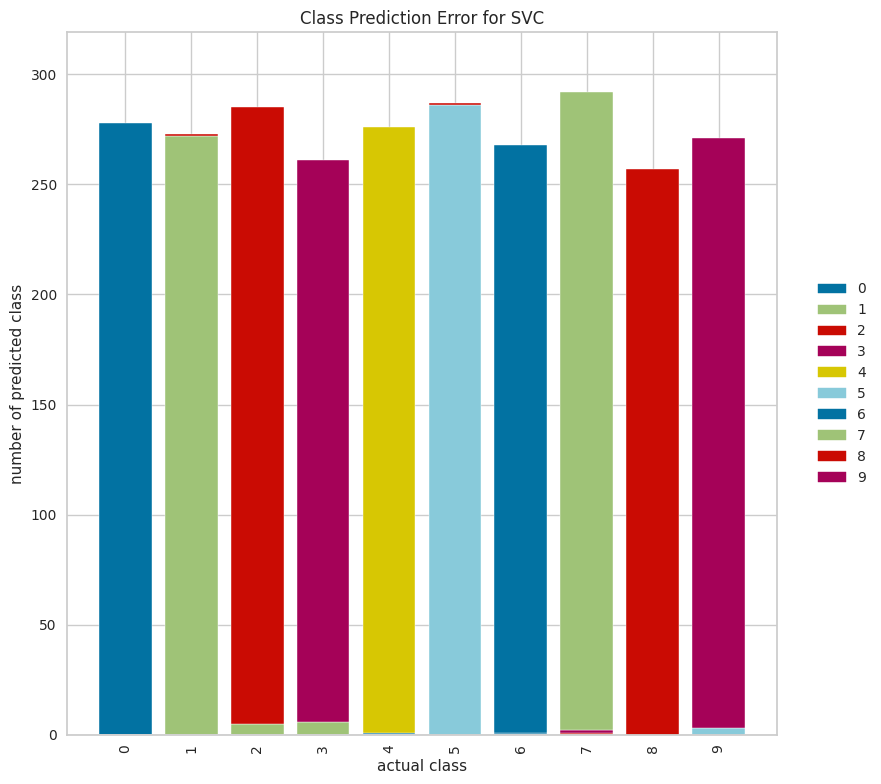

Visualization for svc_model_grid:


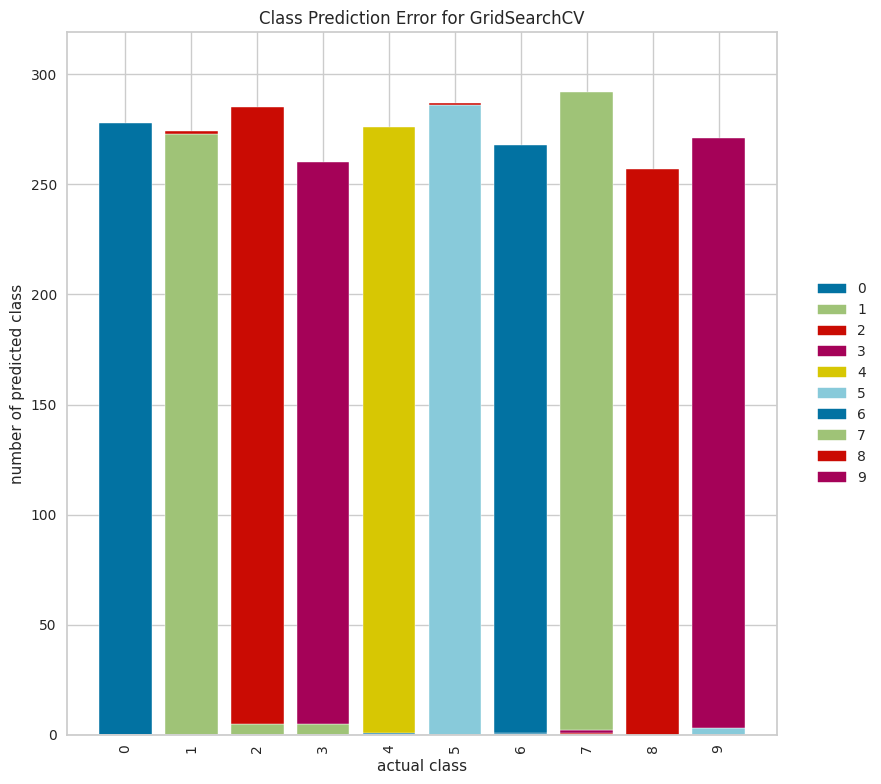

Visualization for rfc:


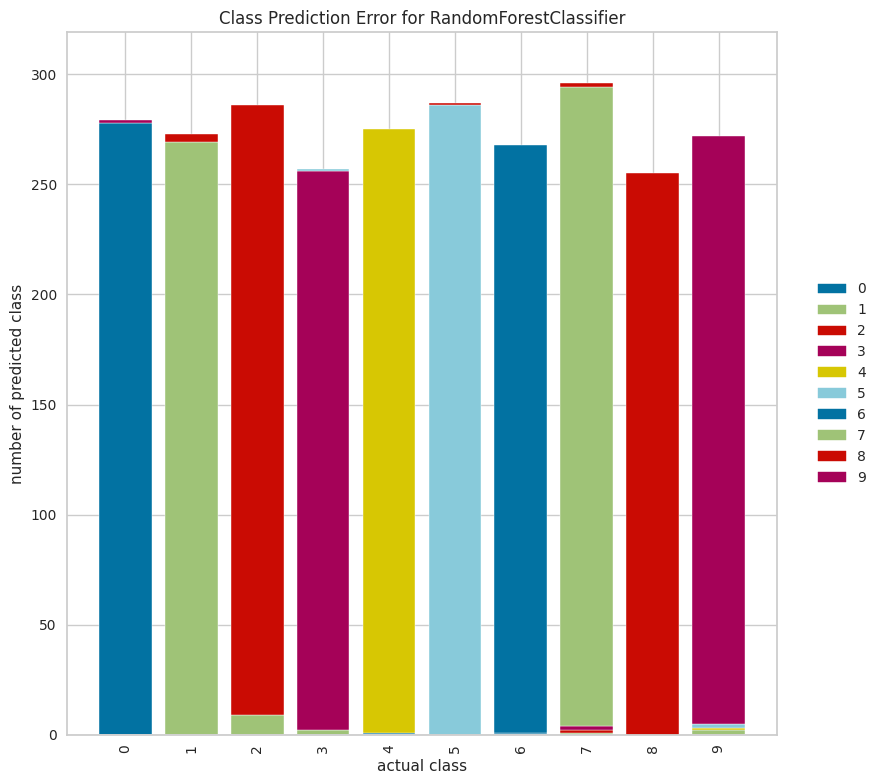

Visualization for rf_grid_model:


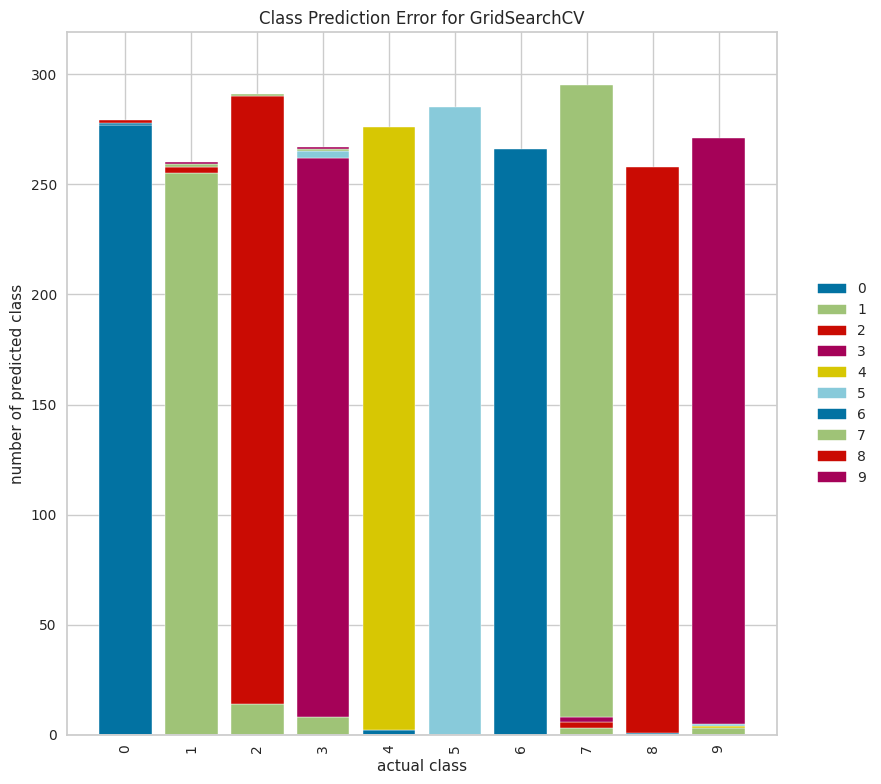

In [28]:
for name, estimator in estimators.items():
    print(f"Visualization for {name}:")
    visualizer = ClassPredictionError(estimator)
    visualizer.fit(data['X_train'], data['y_train'])
    visualizer.score(data['X_test'], data['y_test'])
    visualizer.show()

Visualization for svc_pipeline:


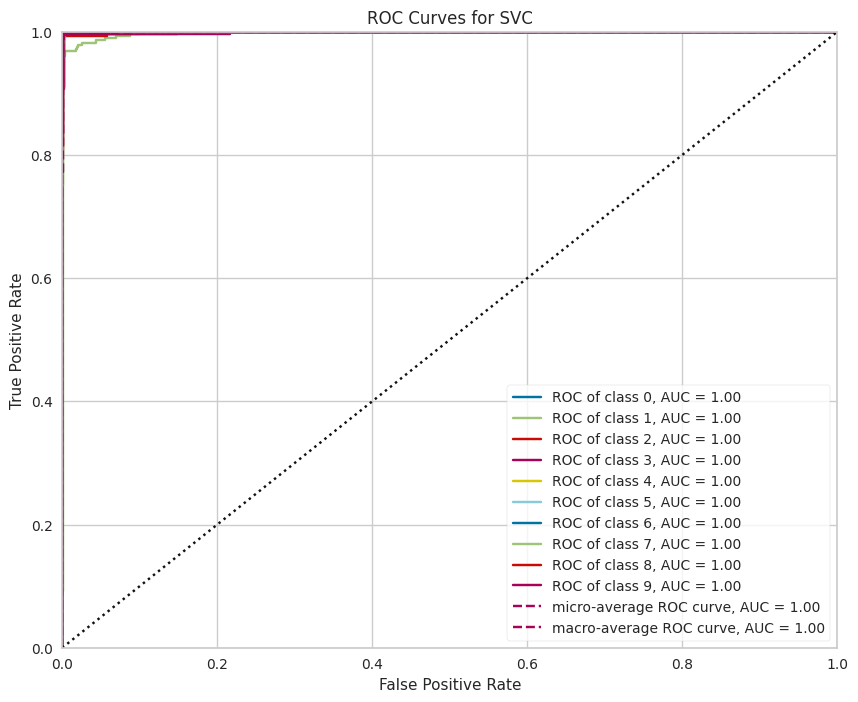

Visualization for svc_model_grid:


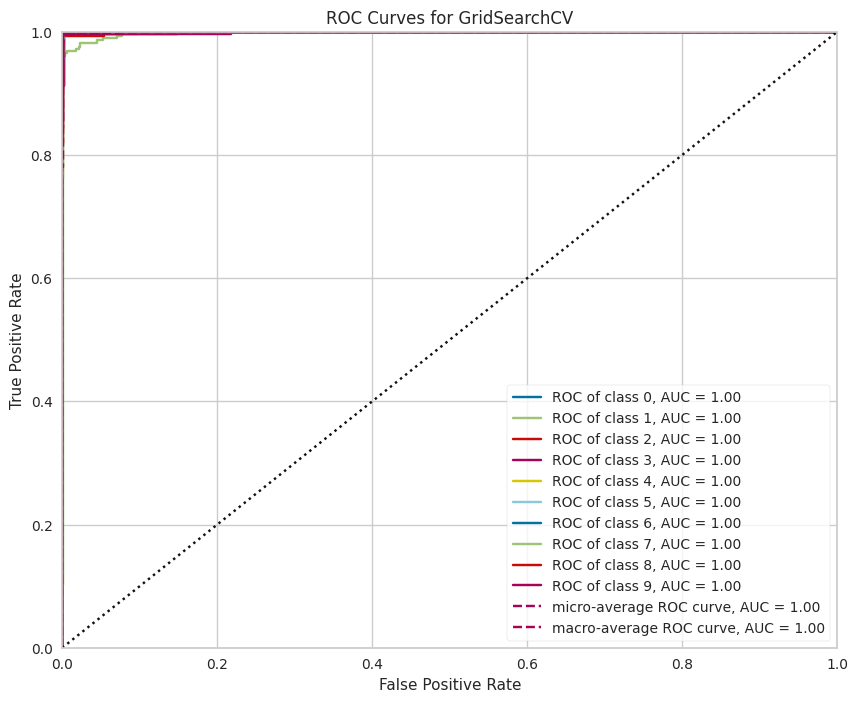

Visualization for rfc:


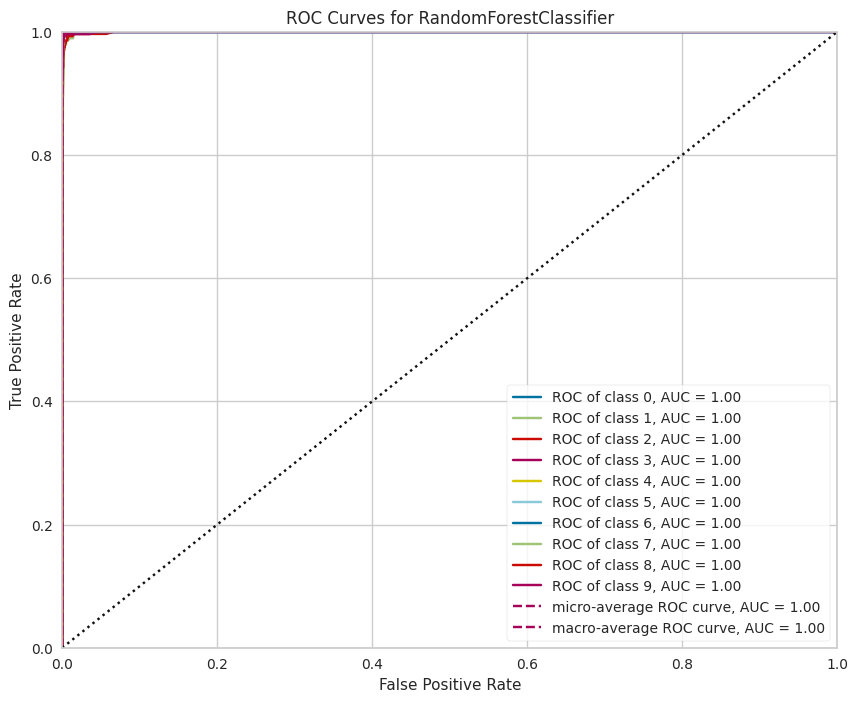

Visualization for rf_grid_model:


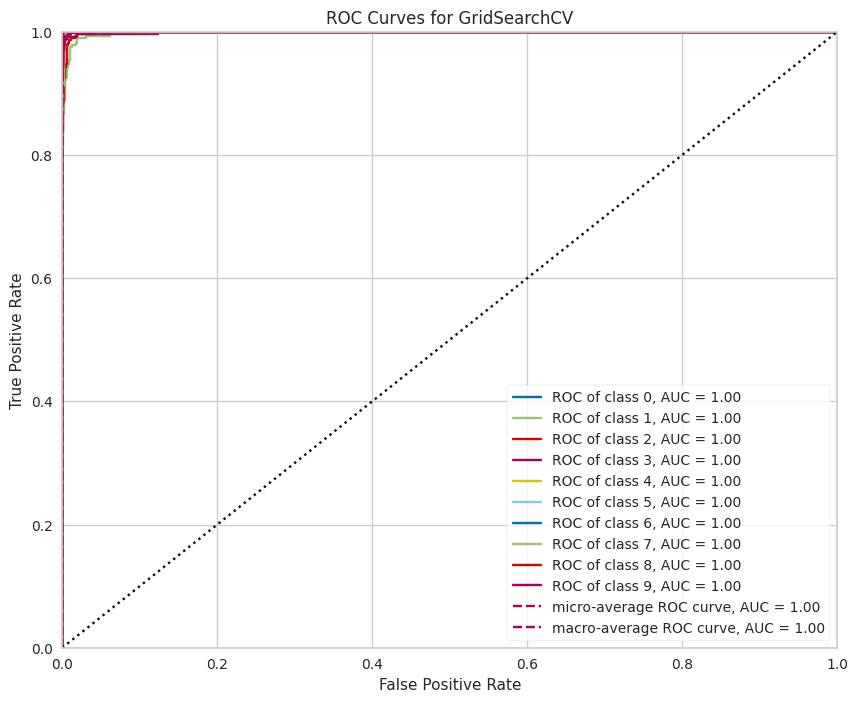

In [29]:
for name, estimator in estimators.items():
    print(f"Visualization for {name}:")
    visualizer = ROCAUC(estimator, classes=[str(i) for i in range(10)])
    visualizer.fit(data['X_train'], data['y_train'])
    visualizer.score(data['X_test'], data['y_test'])
    visualizer.show()

# Compare The Models
## Accuracy Comparison

In [30]:
def plot_performances(model1_metrics, model2_metrics, 
                      model1_name = "SVC", model2_name = "RF",
                      metric_name = "Acc"):
    
    compare = pd.DataFrame({"Model": [model1_name, model2_name],
                        "Accuracy": [model1_metrics, model2_metrics]})

    compare = compare.sort_values(by ="Accuracy", ascending=True)

    plt.figure(figsize=(15,2))
    ax = sns.barplot(x="Accuracy", y = "Model", data=compare, palette="Blues_d")
    for p in ax.patches:
        ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + 0.9),
                    xytext=(5, 10), textcoords='offset points')

    plt.yticks(size = 14)
    plt.xticks(size = 14)
    plt.title(f"Test {metric_name} Score of {model1_name} and {model2_name} Models", size=14)
    plt.tight_layout()
    plt.show()

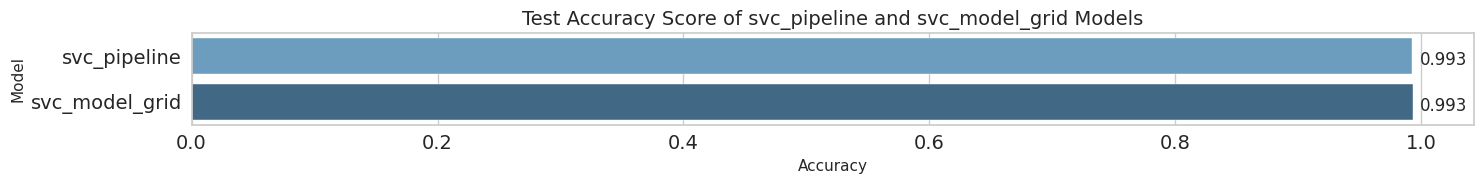

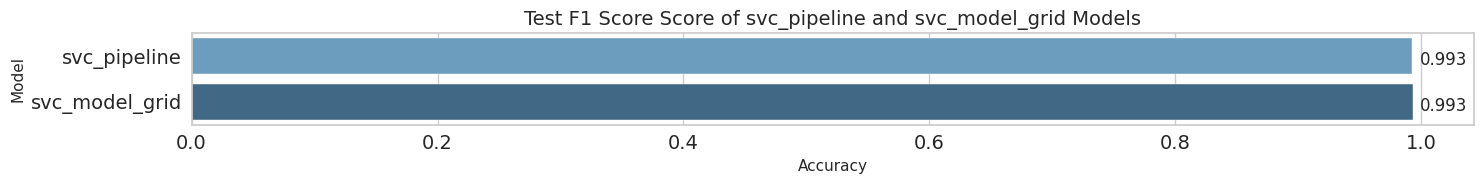

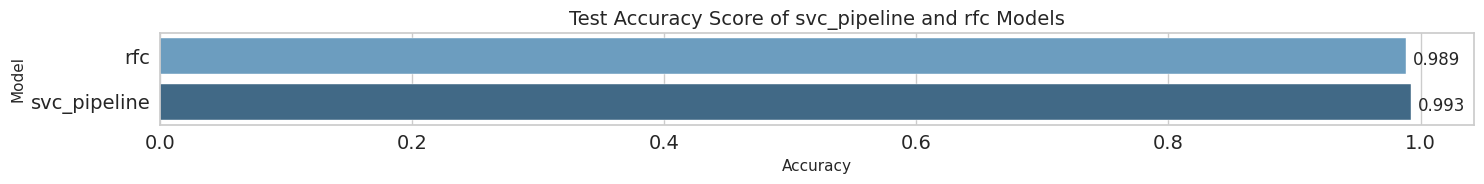

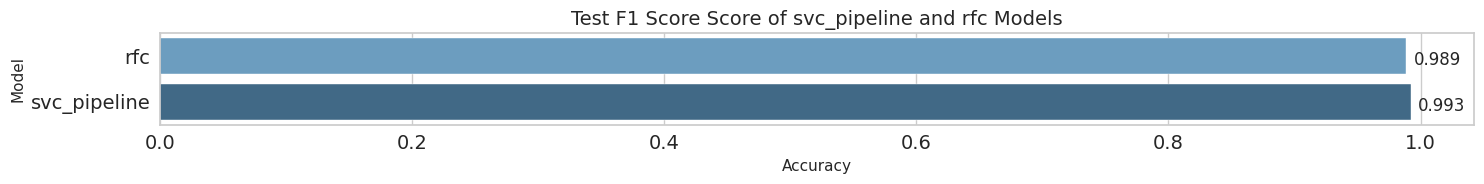

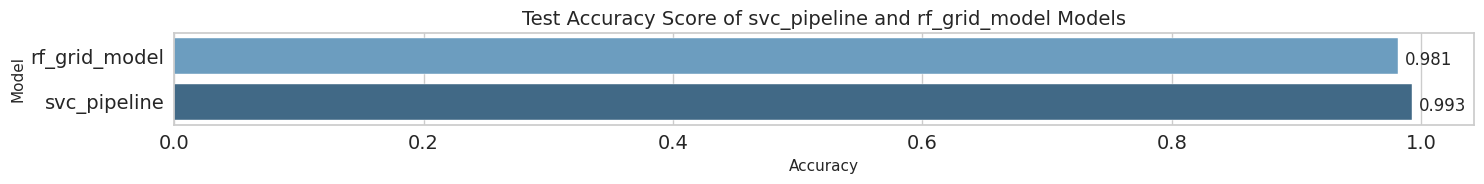

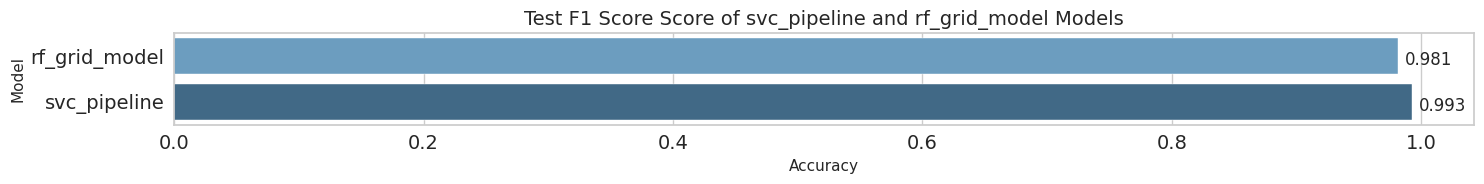

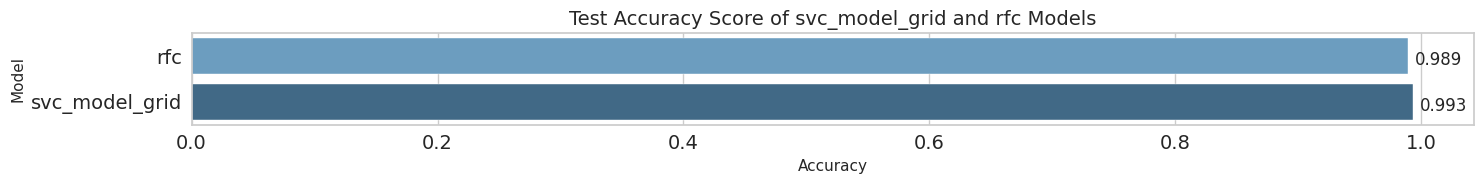

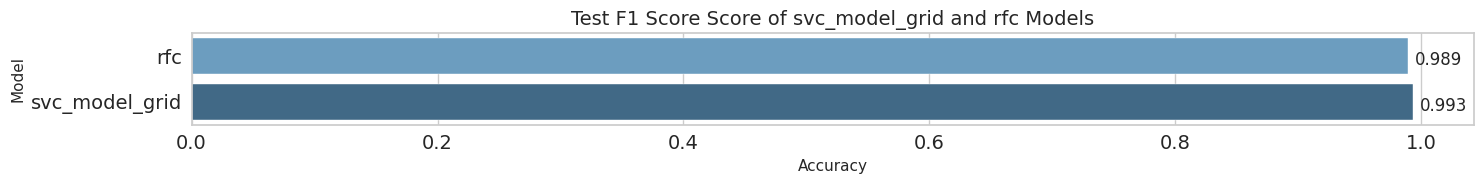

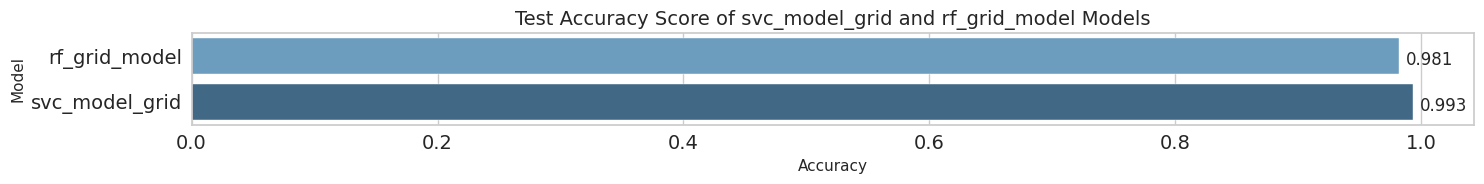

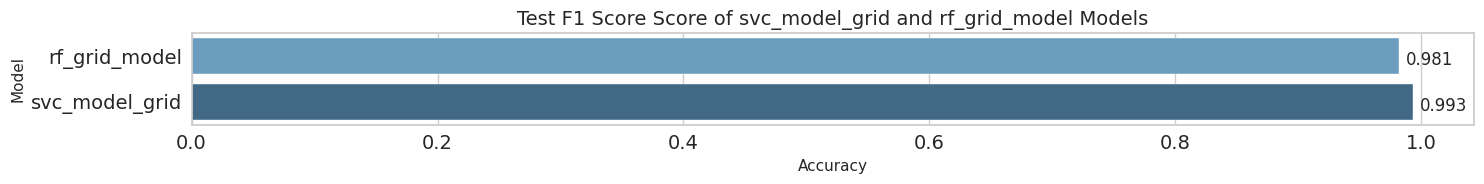

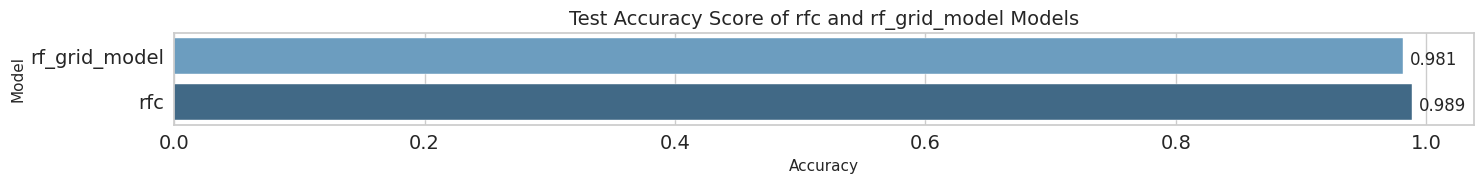

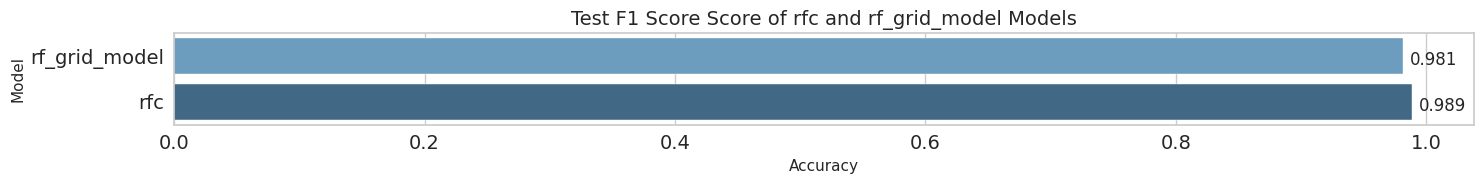

In [31]:
from itertools import combinations

for (name1, result1), (name2, result2) in combinations(results.items(), 2):

    model1_accuracy = result1['test_metrics']['accuracy']
    model2_accuracy = result2['test_metrics']['accuracy']
    plot_performances(model1_accuracy, model2_accuracy, 
                      model1_name=name1, model2_name=name2,
                      metric_name="Accuracy")

    model1_f1 = result1['test_metrics']['f1_score']
    model2_f1 = result2['test_metrics']['f1_score']
    plot_performances(model1_f1, model2_f1, 
                      model1_name=name1, 
                      model2_name=name2,
                      metric_name="F1 Score")